In [42]:
#import library
import zipfile
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime as dt
import calendar
from math import  atan2, radians, sin, cos, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [43]:
#import input file and create dataframe

file_path ='C:\\Users\\pgulhare\\OneDrive - Capgemini\\ds code\\nyc-taxi-trip-duration\\'
f_zip_train = file_path + 'train.zip'
zip_train = zipfile.ZipFile(f_zip_train)
df_train = pd.read_csv(zip_train.open('train.csv'))

In [44]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [45]:
#convert the datetime column into the datetime standard
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [46]:
#check for null values
df_train[pd.isnull(df_train)].sum()

id                    0.0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [47]:
#check the duration of complete data  
print('Minimum datetime is ', min(df_train['pickup_datetime']))
print('Maximum datetime is ', max(df_train['dropoff_datetime']))

Minimum datetime is  2016-01-01 00:00:17
Maximum datetime is  2016-07-01 23:02:03


# Extracting Feature

In [48]:
#extract information from datetime column
#helpful in doing EDA and understanding the data

df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['date'] = df_train['pickup_datetime'].dt.date
df_train['weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['day'] = df_train['pickup_datetime'].apply(lambda x: x.day)
df_train['hour'] = df_train['pickup_datetime'].apply(lambda x : x.hour)

In [49]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,date,weekday,day,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,2016-03-14,0,14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,2016-06-12,6,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,2016-01-19,1,19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,2016-04-06,2,6,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,2016-03-26,5,26,13


In [50]:
#using the latitude, longitude, calculate the trip distance

def cal_distance(row):
    radius = 6373.0
    pickup_latitude = radians(row['pickup_latitude'])
    pickup_longitude = radians(row['pickup_longitude'])
    dropoff_latitude = radians(row['dropoff_latitude'])
    dropoff_longitude = radians(row['dropoff_longitude'])
    
    lon = dropoff_longitude - pickup_longitude
    lat = dropoff_latitude - pickup_latitude
    a = sin(lat / 2)** 2 + cos(pickup_latitude) * cos(dropoff_latitude) * sin(lon / 2)**2
    dist = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = radius * dist
    return distance
df_train['trip_distance'] = df_train.apply(lambda row : cal_distance(row), axis = 1)

In [51]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,date,weekday,day,hour,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,2016-03-14,0,14,17,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,2016-06-12,6,12,0,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,2016-01-19,1,19,11,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,2016-04-06,2,6,19,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,2016-03-26,5,26,13,1.188962


# EDA

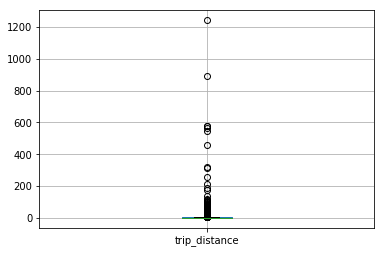

In [52]:
#distance outliner identification
df_train.boxplot(column='trip_distance')

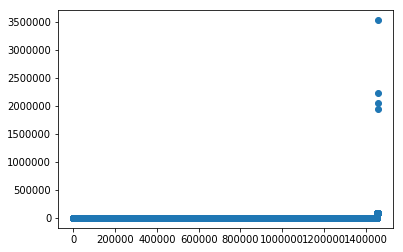

In [53]:
#visualise outliner trip duration
plt.scatter(range(df_train.shape[0]),np.sort(df_train['trip_duration']))

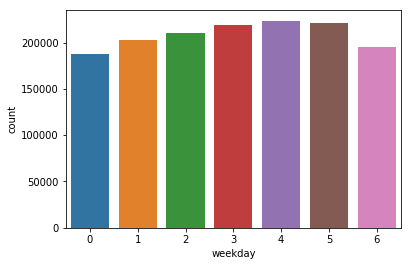

In [54]:
#visualise week of day trip count
sns.countplot(df_train['weekday'])
#thursday , friday, saturday are the most number of taxis

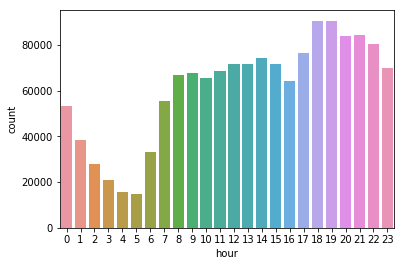

In [55]:
sns.countplot(df_train['hour'])

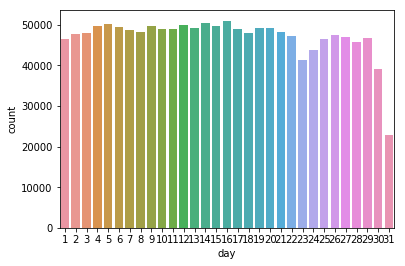

In [56]:
sns.countplot(df_train['day'])

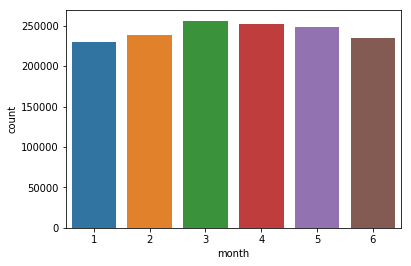

In [57]:
sns.countplot(df_train['month'])

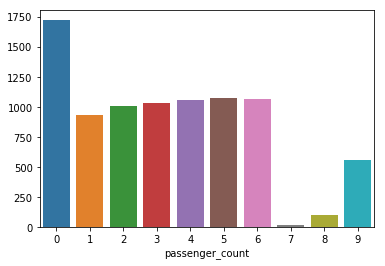

In [58]:
pc = df_train.groupby('passenger_count')['trip_duration'].mean()
sns.barplot(pc.index,pc.values)

In [82]:
pickup = df_train.groupby(['pickup_latitude','pickup_longitude'])['id'].count().reset_index().rename(columns = {'id':'Num_Trips'})
pickup['Num_Trips'] = pickup['Num_Trips'].astype('float64')
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = folium.plugins.HeatMap(list(zip(pickup.pickup_latitude.values, 
                           pickup.pickup_longitude.values,
                           pickup.Num_Trips.values)),
                  min_opacity = 0.2,
                  radius = 5, blur = 15,
                  max_zoom = 1)
pickup_map.add_child(hm_wide)

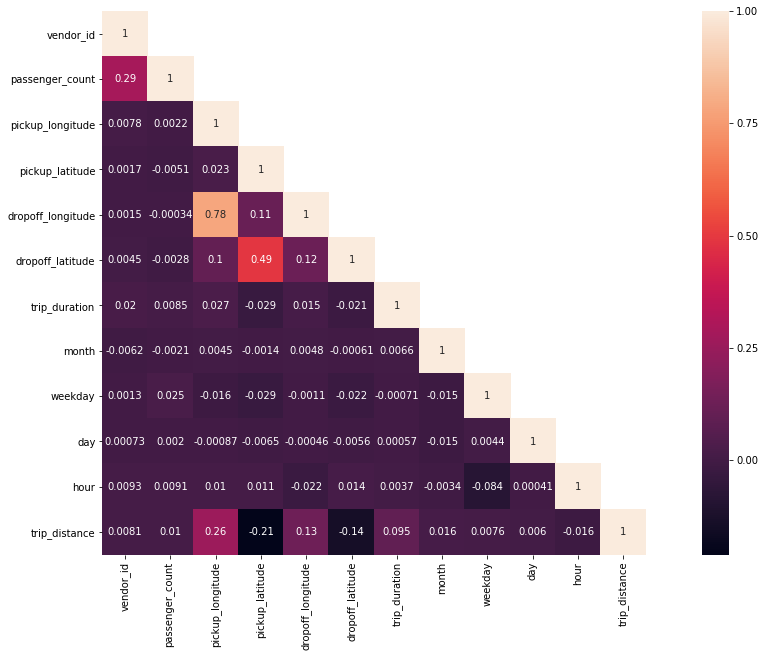

In [60]:
#checking the correlation
cor = df_train.corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(cor,mask= mask,square=True,annot=True)

In [61]:
#encoding the feature columns
df_train = pd.concat([df_train, pd.get_dummies(df_train['store_and_fwd_flag'],prefix = 'store')], axis=1)
df_train.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df_train = pd.concat([df_train, pd.get_dummies(df_train['vendor_id'],prefix = 'vendor')], axis=1)
df_train.drop(['vendor_id'], axis=1, inplace=True)

In [62]:
#drop columns 
df_train = df_train.drop(['id','dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude','pickup_datetime','dropoff_datetime','month','day','date','weekday'], axis=1)

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   passenger_count  1458644 non-null  int64  
 1   trip_duration    1458644 non-null  int64  
 2   hour             1458644 non-null  int64  
 3   trip_distance    1458644 non-null  float64
 4   store_N          1458644 non-null  uint8  
 5   store_Y          1458644 non-null  uint8  
 6   vendor_1         1458644 non-null  uint8  
 7   vendor_2         1458644 non-null  uint8  
dtypes: float64(1), int64(3), uint8(4)
memory usage: 50.1 MB


# Model Building, Training

In [64]:
#create X and y
y = df_train["trip_duration"].copy().to_numpy().reshape(-1,1)
X = df_train.drop(["trip_duration"], axis=1)


In [65]:
X.head()

,passenger_count,hour,trip_distance,store_N,store_Y,vendor_1,vendor_2
0,1,17,1.498991,1,0,0,1
1,1,0,1.806074,1,0,1,0
2,1,11,6.387103,1,0,0,1
3,1,19,1.485965,1,0,0,1
4,1,13,1.188962,1,0,0,1


In [66]:
#divide the training data into the train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [67]:
X_train.head()
X_val.head()

,passenger_count,hour,trip_distance,store_N,store_Y,vendor_1,vendor_2
67250,1,7,2.763917,1,0,0,1
1397036,1,12,1.959793,1,0,0,1
1021087,5,2,1.405213,1,0,0,1
951424,2,17,1.979281,1,0,0,1
707882,4,17,20.844286,1,0,1,0


In [68]:
#using Linear Regression to train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
#validation
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

In [70]:
#calculate mae
mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"mae: {mae}, val_mae: {val_mae}")

mae: 468.9172351706147, val_mae: 461.9858745072237


In [71]:
#using Linear Regression SGD
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)

In [72]:
X_val.head()

,passenger_count,hour,trip_distance,store_N,store_Y,vendor_1,vendor_2
67250,1,7,2.763917,1,0,0,1
1397036,1,12,1.959793,1,0,0,1
1021087,5,2,1.405213,1,0,0,1
951424,2,17,1.979281,1,0,0,1
707882,4,17,20.844286,1,0,1,0


In [73]:
#fit validate
sgd_model.fit(X_train, y_train)
y_train_pred = sgd_model.predict(X_train)
y_val_pred = sgd_model.predict(X_val)

In [74]:
#calculate mae in SGD
mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"mae: {mae}, val_mae: {val_mae}")

mae: 596.4352986466444, val_mae: 588.8109196901205


# Prediction 

In [75]:
#input file
f_zip_test = file_path + 'test.zip'
zip_test = zipfile.ZipFile(f_zip_test)
df_test = pd.read_csv(zip_test.open('test.csv'))
df_predict = df_test[['id']].copy()

In [76]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [77]:
#data manupulation
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df_test['hour'] = df_test['pickup_datetime'].apply(lambda x : x.hour)
df_test['trip_distance'] = df_test.apply(lambda row : cal_distance(row), axis = 1)
#encoding the feature columns
df_test = pd.concat([df_test, pd.get_dummies(df_test['store_and_fwd_flag'],prefix = 'store')], axis=1)
df_test.drop(['store_and_fwd_flag'], axis=1, inplace=True)
df_test = pd.concat([df_test, pd.get_dummies(df_test['vendor_id'],prefix = 'vendor')], axis=1)
df_test.drop(['vendor_id'], axis=1, inplace=True)
df_test = df_test.drop(['id','dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude','pickup_datetime'], axis=1)


In [78]:
#prediciton on test data
df_test['trip_duration_in_sec'] = lr_model.predict(df_test).astype(int)

In [79]:
df_predict = pd.concat([df_predict, df_test], axis=1)
df_predict = df_predict[['id', 'trip_duration_in_sec']]

In [80]:
df_predict.head()

,id,trip_duration_in_sec
0,id3004672,815
1,id3505355,817
2,id1217141,652
3,id2150126,1294
4,id1598245,613


In [81]:
#write the predition into a file
NYC_Taxi_time_pred_path = file_path + 'NYC_Taxi_time_pred' + dt.datetime.now().strftime("%Y%m%d") + '.csv'
df_predict.to_csv(NYC_Taxi_time_pred_path)